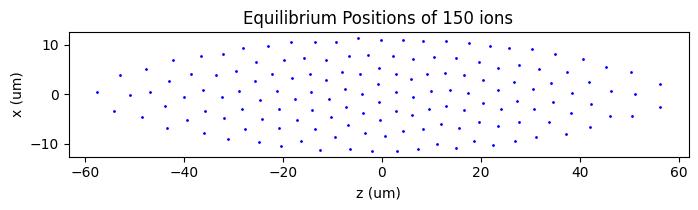

In [4]:
# 计算平衡位置
import os
import numpy as np
import matplotlib.pyplot as plt
N = 150
dt = 9.022389064166401e-03  # us
start = 31.578
dir_name = "../data_cache/traj/%d/r/"%(N)
Nt = len(list(os.listdir(dir_name)))
t_ls = np.arange(1, Nt+1)*dt + start
traj_r = np.zeros((Nt, N, 3))
for t in range(Nt):
        rt = np.load(dir_name+"%.3fus.npy"%t_ls[t])
        traj_r[t] = rt
r_eq = np.mean(traj_r, axis=0) 
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(r_eq[:, 2], r_eq[:, 0], s=1, c='blue')
ax.set_xlabel('z (um)')
ax.set_ylabel('x (um)')
ax.set_title('Equilibrium Positions of %d ions'%N)
ax.set_aspect('equal', 'box')
plt.show()

In [8]:
# Hc
# CPU Parallel in Hc
from scipy.constants import e, pi, epsilon_0
from concurrent.futures import ProcessPoolExecutor
from numpy.linalg import norm, eigvalsh
import time
import numpy as np

def hessian_i(i, R):
    start_i = time.time()
    res = np.zeros((3, 3*N))
    for j in range(N):
        if i == j:
            continue
        else:
            rij = R[i] - R[j]
            r = norm(rij) + 1e-20
            outer = np.outer(rij, rij)
            block = np.eye(3)/(r**3) - 3*outer/(r**5)
            # 对称填充 Hessian
            res[:, 3*j:3*j+3] = block
    res[:, 3*i:3*i+3] = -sum(res[:, 3*j:3*j+3] for j in range(N))
    end_i = time.time()
    print("Finished %d, taking %.3f s"%(i, end_i-start_i))
    return i, res

def hessian_parallel(R):
    R = R.reshape(N, 3)
    H = np.zeros((3*N, 3*N))
    with ProcessPoolExecutor(max_workers=12) as executor:
        futures = [executor.submit(hessian_i, i, R) for i in range(N)]
        for future in futures:
            i, res = future.result()
            H[3*i:3*i+3, :] = res
    return H*e**2/(4*pi*epsilon_0)

if __name__ == "__main__":
    r = r_eq
    N = r.shape[0]
    start = time.time()
    Hc = hessian_parallel(r*1e-6)  # SI
    # np.save("../data_cache/%d/hessian_coulomb.npy"%N, Hc)
    end = time.time()
    print(end-start)

Finished 0, taking 0.001 sFinished 1, taking 0.001 sFinished 6, taking 0.001 sFinished 4, taking 0.001 sFinished 8, taking 0.001 sFinished 3, taking 0.001 sFinished 2, taking 0.001 s
Finished 5, taking 0.001 s
Finished 10, taking 0.001 sFinished 11, taking 0.001 s




Finished 9, taking 0.003 s
Finished 7, taking 0.003 s

Finished 12, taking 0.001 sFinished 13, taking 0.001 sFinished 14, taking 0.001 s
Finished 16, taking 0.001 sFinished 17, taking 0.001 s
Finished 15, taking 0.001 s
Finished 18, taking 0.001 s
Finished 19, taking 0.001 s
Finished 21, taking 0.001 s
Finished 20, taking 0.002 s





Finished 22, taking 0.002 sFinished 23, taking 0.001 sFinished 24, taking 0.002 sFinished 26, taking 0.001 sFinished 25, taking 0.002 sFinished 27, taking 0.001 s
Finished 28, taking 0.001 s


Finished 29, taking 0.001 s


Finished 30, taking 0.001 sFinished 32, taking 0.001 s
Finished 33, taking 0.001 s
Finished 35, taking 0.001 sFinished 34, taking 0.001 s

Finished 37, taking 0.001 s

Fin

Finished 79, taking 0.003 s
Finished 83, taking 0.002 sFinished 84, taking 0.002 sFinished 80, taking 0.003 sFinished 78, taking 0.004 s

Finished 82, taking 0.003 s


Finished 88, taking 0.002 sFinished 86, taking 0.002 s

Finished 85, taking 0.002 sFinished 87, taking 0.003 sFinished 90, taking 0.002 s
Finished 89, taking 0.004 s


Finished 94, taking 0.002 sFinished 92, taking 0.003 sFinished 95, taking 0.002 s
Finished 93, taking 0.003 s
Finished 96, taking 0.002 s
Finished 91, taking 0.004 s



Finished 99, taking 0.002 s
Finished 97, taking 0.004 sFinished 98, taking 0.003 s
Finished 100, taking 0.002 sFinished 103, taking 0.002 sFinished 101, taking 0.003 sFinished 102, taking 0.003 sFinished 104, taking 0.002 sFinished 106, taking 0.002 s

Finished 105, taking 0.003 s



Finished 108, taking 0.002 sFinished 107, taking 0.003 s




Finished 111, taking 0.002 sFinished 114, taking 0.002 sFinished 113, taking 0.002 sFinished 109, taking 0.003 sFinished 110, taking 0.003 sFinished 

In [9]:
print(np.max(Hc), np.min(Hc), np.mean(np.abs(Hc)))

2.702180168581897e-11 -4.0333729120976275e-11 1.3633500848320176e-13


In [10]:
# Hf
fx = 0.9926366729551477*1e6
fy = 2.0506600594125324*1e6
fz = 0.09298249214574596*1e6
wx, wy, wz = 2*pi*fx, 2*pi*fy, 2*pi*fz
m = 2.239367e-25  # kg
Hf = np.zeros((3*N, 3*N))
for i in range(N):
    Hf[3*i, 3*i] = m*wx**2
    Hf[3*i+1, 3*i+1] = m*wy**2
    Hf[3*i+2, 3*i+2] = m*wz**2
print(np.max(Hf), np.min(Hf), np.mean(np.abs(Hf)))

3.717683006538206e-11 0.0 3.404756789148909e-14


In [ ]:
# H
H = Hc + Hf
eigenvalues = eigvalsh(H)
frequencies = np.sqrt(np.abs( eigenvalues)/m)/(2*pi*1e6)  #MHz
print(np.max(frequencies), np.min(frequencies), np.mean(frequencies))

2.4283339146791807 0.02193145850862364 1.2192490782508918


In [23]:
mask = frequencies>2.05
print("Number of modes above 2.05 MHz:", np.sum(mask))

Number of modes above 2.05 MHz: 36


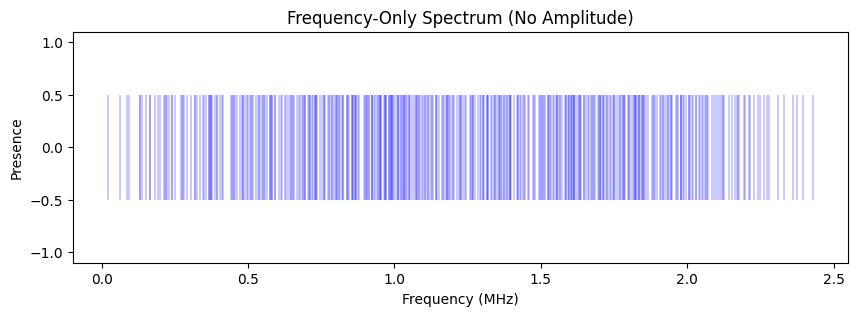

In [22]:
plt.figure(figsize=(10, 3))
plt.eventplot(frequencies, lineoffsets=0, linelengths=1, orientation='horizontal', colors='blue', linewidths=0.3)
plt.xlabel("Frequency (MHz)")
plt.ylabel("Presence")
plt.title("Frequency-Only Spectrum (No Amplitude)")
plt.show()